In [1]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import random
import torch.nn.functional as F
import matplotlib.colors as mcolors


In [2]:
class Linear_net_rej_id(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim, k):
        super(Linear_net_rej_id, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+k) # out: 0,1,2,3
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2,3 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

In [3]:
def reject_CrossEntropyLoss_id(outputs, h, labels, m, k, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert k cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes, binary here
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs_exp = [torch.zeros(batch_size) for _ in range(k)]

    for i in range(k):
        outputs_exp[i] = -h[i] * torch.log2(outputs[range(batch_size), rc]) - m[:, i] * torch.log2(outputs[range(batch_size), labels])

    outputs = sum(outputs_exp)  # Sum the losses from all experts
    
    return torch.sum(outputs) / batch_size

In [4]:
def run_classifier_rej_id_rand(model, exp_heuristic_id, exp_heuristic_rand, data_x, data_y, alpha, p, k):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: expert 1 hyperparam alpha for loss L_CE^{\alpha} 
        p: probability of randomly selecting expert 
    '''
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.08, betas = (0.75, .1), weight_decay=.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

    c = len(exp_heuristic_rand)
    z = k - c

    for epoch in range(1):  # loop over the dataset multiple times
        inputs = data_x
        inputs= inputs.clone().detach()
        labels = data_y
        labels = labels.clone().detach()

        # split to create batch size
        x_batches = torch.split(inputs, 5)
        y_batches = torch.split(labels, 5) 

        loss_train = []

        for inputs, labels in zip(x_batches, y_batches):
            optimizer.zero_grad()

            # k arrays of 5 predictions (batch size), separate so this is only for experts we know ID?
            predicted = [torch.tensor(expert(inputs)) for expert in exp_heuristic_id]

            rand_exp = random.choices([1, c], weights=[p, 1-p])[0] # randomly select expert k
            predicted_rand = torch.tensor(exp_heuristic_rand[rand_exp-1](inputs))  # get predictions from selected expert

            predicted.append(predicted_rand)

            h_list = [(expert_output == labels) * 1 for expert_output in predicted]

            m = torch.zeros(len(inputs), k-1)

            for j in range(len(inputs)):
                for i in range(k-1):
                    if h_list[i][j]:
                        m[j][i] = alpha
                    else:
                        m[j][i] = 1

            h_list = [h.clone().detach() for h in h_list]
            m = m.clone().detach()

            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)

            # Loss computation
            loss = reject_CrossEntropyLoss_id(outputs, h_list, labels, m, k-1, 2)
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train.append(loss.item())
    plt.plot(loss_train, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()  

In [98]:
def classifier_rej_id_rand(model, exp_heuristic_id, exp_heuristic_rand, exp_id, data_x, data_y, p, k, exp_instances_rand, exp_instances_id, classifier_instances):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    c = len(exp_heuristic_rand)
    z = k - c

    correct = 0
    correct_sys = 0
    id_exp = [0]*z
    id_exp_total = [0]*z
    r_exp = [0]*c
    r_exp_total = [0]*c
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #0/1 (ML), 2 (defer to expert)
        predicted_exp_id = [torch.tensor(exp_heuristic(inputs)) for exp_heuristic in exp_heuristic_id]
        predicted_exp_rand = [torch.tensor(exp_heuristic(inputs)) for exp_heuristic in exp_heuristic_rand]

        for i in range(len(inputs)):
            r = ((predicted[i] > 1)).item() # if not 0 or 1, then defer to expert
            if r:
                expert_id = predicted[i].item() - 2  # expert index starts from 0
                if expert_id in exp_id:
                    correct_sys += (predicted_exp_id[expert_id][i] == labels[i]).item()
                    id_exp[expert_id] += (predicted_exp_id[expert_id][i] == labels[i]).item()
                    id_exp_total[expert_id] += 1
                    exp_instances_id[expert_id].append(i)

                else:
                    rand_exp = random.choices([1, c], weights=[p, 1-p])[0] # randomly select expert for each point
                    correct_sys += (predicted_exp_rand[rand_exp-1][i] == labels[i]).item()
                    r_exp[rand_exp-1] += (predicted_exp_rand[rand_exp-1][i] == labels[i]).item()
                    r_exp_total[rand_exp-1] += 1
                    exp_instances_rand[rand_exp-1].append(i)
            else: 
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
                classifier_instances.append(i)
        real_total += labels.size(0)

    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()

    for idx, (cnt, expert_total) in enumerate(zip(id_exp, id_exp_total)):
        print(f"Expert {idx+1} defer count:", expert_total)
        print(f"Expert {idx+1} defer percent:", 100 * expert_total / points if expert_total != 0 else 0)
        print(f"Expert {idx+1} correct predictions:", cnt)
        print(f"Expert {idx+1} accuracy:", 100 * cnt / (expert_total + 0.0002) if expert_total != 0 else 0)
        print()

    for idx, (cnt, expert_total) in enumerate(zip(r_exp, r_exp_total)):
        print(f"Expert {idx+3} defer count:", expert_total)
        print(f"Expert {idx+3} defer percent:", 100 * expert_total / points if expert_total != 0 else 0)
        print(f"Expert {idx+3} correct predictions:", cnt)
        print(f"Expert {idx+3} accuracy:", 100 * cnt / (expert_total + 0.0002) if expert_total != 0 else 0)
        print()

    print("Not deferred to any expert count:", total)
    print("Not deferred percent:", 100 * total / points)
    print("Model correct predictions:", correct)
    print("Model accuracy:", 100 * correct / (total + 0.0001))

    print()
    overall_exp_total = sum(r_exp_total+id_exp_total)
    overall_exp_correct = sum(r_exp+id_exp)
    print("Overall expert count:", overall_exp_total)
    print("Overall expert defer percent:", 100 * overall_exp_total / points)
    print("Overall expert correct predictions:", overall_exp_correct)
    print("Overall expert accuracy:", 100 * overall_exp_correct / (overall_exp_total + 0.0001) if overall_exp_total != 0 else 0)

    return exp_instances_rand, exp_instances_id, classifier_instances

In [68]:
def getSyntheticDataset(m_values, s_values, sizes, flip_prob=0.5):
    X, y, groups = [], [], []
    num_clusters = len(m_values)
    index_to_group = {} 
    index_counter = 0
    
    # Generate data for each cluster
    for cluster_idx in range(num_clusters):
        m = m_values[cluster_idx]
        s = s_values[cluster_idx]
        total = sizes[cluster_idx]
        
        # Generate data points for the current cluster
        mu = np.array(m)  # Mean vector for the cluster
        sig = np.diag([s for _ in range(len(m))])  # Diagonal covariance matrix
        
        cluster_data = np.random.multivariate_normal(mu, sig, total)
        X.extend(cluster_data)
        
        # Assign labels and groups
        if cluster_idx == 0:
            # Assign label 0 for all data points in the first cluster
            labels = [0] * total
        elif cluster_idx == 1:
            # Assign label 1 for all data points in the second cluster
            labels = [1] * total
        else:
            # Assign labels randomly based on flip_prob for other clusters
            labels = np.random.choice([0, 1], size=total, p=[1 - flip_prob, flip_prob])
        
        y.extend(labels)
        groups.extend([cluster_idx] * total)

        # Map index to group for each data point
        for i in range(total):
            index_to_group[index_counter] = cluster_idx
            index_counter += 1  # Increment index counter

    return X, y, groups, index_to_group

In [38]:
def visualize_clusters(X, y, groups, sizes):
    import itertools
    colors = ["orange", "orange", "blue", "green", "gray", "red"]
    markers = [".", "+"]

    indices = list(range(np.sum(sizes)))
    random.shuffle(indices)
    # indices = indices[:500]

    for label, group in itertools.product(np.unique(y), np.unique(groups)):
        x1 = [X[i][0] for i in indices if y[i]==label and groups[i]==group]
        x2 = [X[i][1] for i in indices if y[i]==label and groups[i]==group]
    
        #leg = "Group " + str(group) + ", Label " + str(label)
        plt.scatter(x1, x2, c=colors[group], marker=markers[label], s=100)
    #plt.legend(ncol=2)

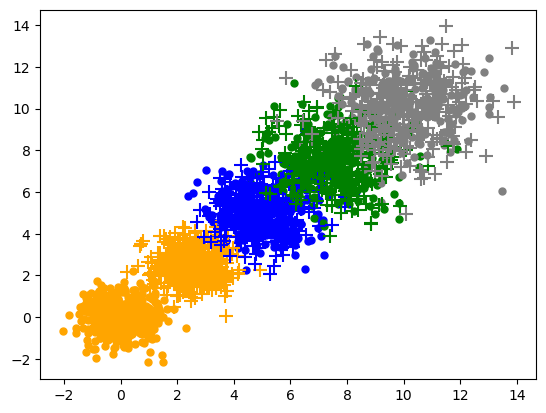

In [69]:
k = 6  # Number of clusters

# Define parameters for each cluster 
m_values = [
    [0, 0],    # Cluster 1
    [2.5, 2.5], # Cluster 2
    [5, 5],    # Cluster 3
    [7.5, 7.5], # Cluster 4
    [10, 10]   # Cluster 5
]

s_values = [0.5, 0.5, 1.0, 1.5, 2.0]  # Standard deviation for each cluster
sizes = [500, 500, 500, 500, 500]     # Number of data points for each cluster

# Generate synthetic dataset with k clusters
X, y, groups, group_index = getSyntheticDataset(m_values, s_values, sizes)

# Visualize clusters
visualize_clusters(X, y, groups, sizes)

In [71]:
X = torch.tensor(X)
y = torch.tensor(y)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [110]:
# Expert 1
exp_1 = DecisionTreeClassifier().fit(X[1000:1500], y[1000:1500])

# Expert 2
exp_2 = DecisionTreeClassifier().fit(X[1500:2000], y[1500:2000])

exp_3 = DecisionTreeClassifier().fit(X[2000:2500], y[2000:2500])

#exp_4 = DecisionTreeClassifier().fit(X[2500:3000], y[2500:3000])

In [74]:
def expert1(inputs):
    return exp_1.predict(inputs)

def expert2(inputs):
    return exp_2.predict(inputs)

def expert3(inputs):
    return exp_3.predict(inputs)

#def expert4(inputs):
    #return exp_4.predict(inputs)

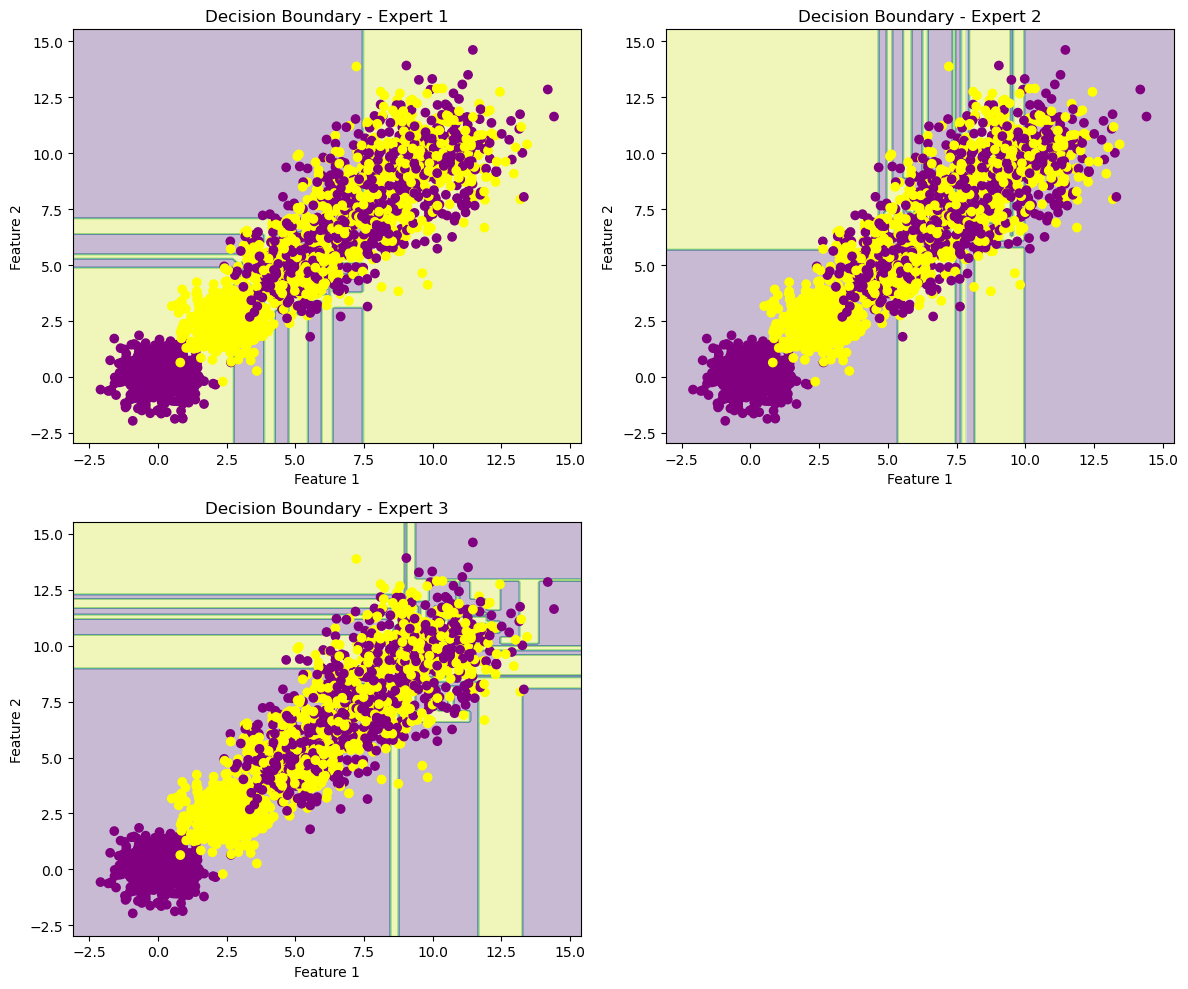

In [14]:
custom_colors = ['purple', 'yellow']
custom_cmap = mcolors.ListedColormap(custom_colors)

# Create a mesh grid to plot the decision boundaries
# Define the range for feature 1 and feature 2
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Create a meshgrid
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Concatenate xx and yy to create input data for predictions
mesh_input = np.c_[xx.ravel(), yy.ravel()]

# Get predictions from each expert for the mesh input
predictions_expert1 = expert1(mesh_input).reshape(xx.shape)
predictions_expert2 = expert2(mesh_input).reshape(xx.shape)
predictions_expert3 = expert3(mesh_input).reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(12, 10))

# Plot decision boundaries for Expert 1
plt.subplot(2, 2, 1)
plt.contourf(xx, yy, predictions_expert1, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap)
plt.title('Decision Boundary - Expert 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot decision boundaries for Expert 2
plt.subplot(2, 2, 2)
plt.contourf(xx, yy, predictions_expert2, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap)
plt.title('Decision Boundary - Expert 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot decision boundaries for Expert 3
plt.subplot(2, 2, 3)
plt.contourf(xx, yy, predictions_expert3, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap)
plt.title('Decision Boundary - Expert 3')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()


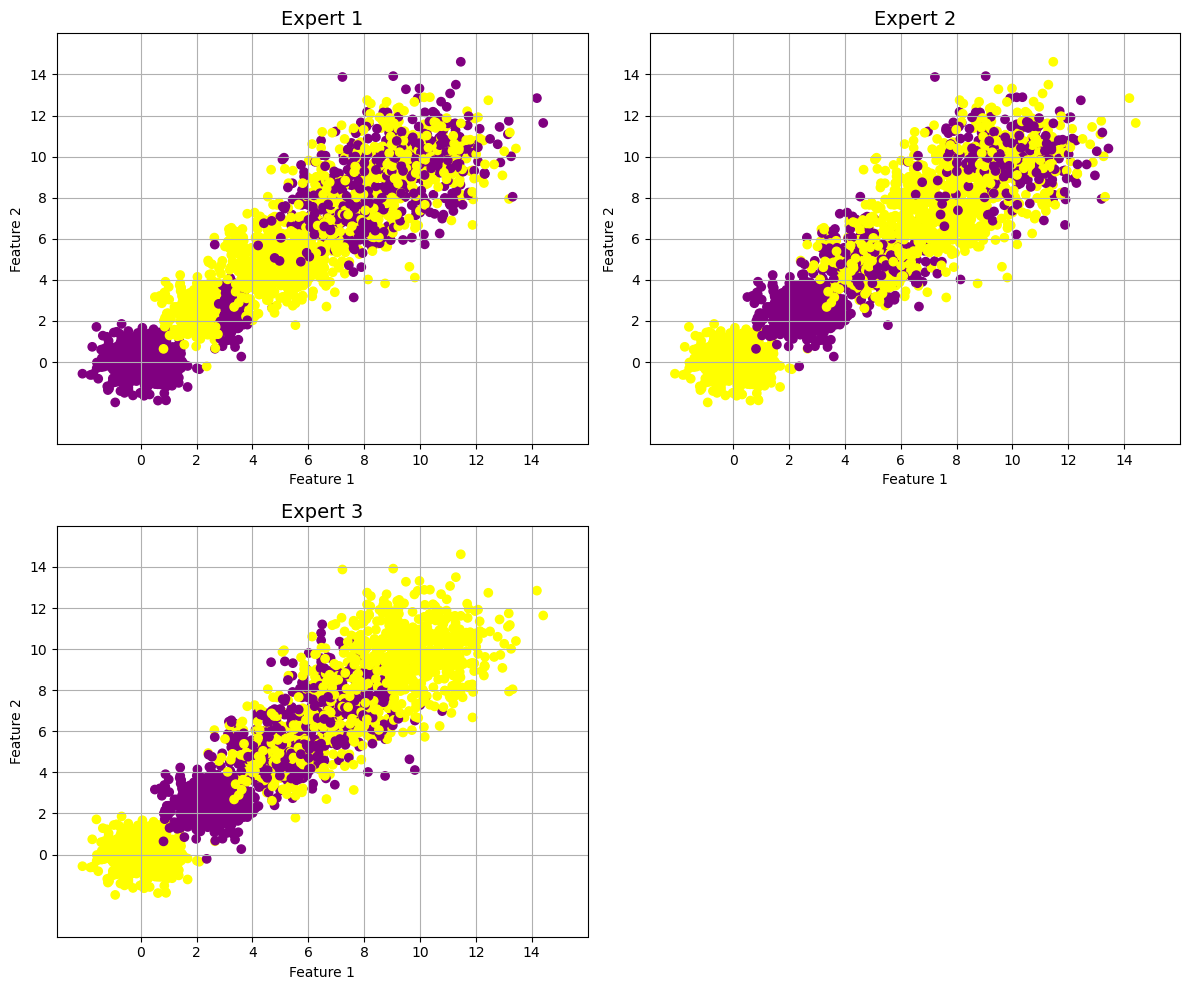

In [15]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))
plt.xlim(-3, 16)
plt.ylim(-4, 16)
plt.scatter(X[:, 0], X[:, 1], c = (torch.tensor(expert1(X)) == y)*1, cmap=custom_cmap)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))
plt.xlim(-3, 16)
plt.ylim(-4, 16)
plt.scatter(X[:, 0], X[:, 1], c = (torch.tensor(expert2(X)) == y)*1, cmap=custom_cmap)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Expert 3', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))
plt.xlim(-3, 16)
plt.ylim(-4, 16)
plt.scatter(X[:, 0], X[:, 1], c = (torch.tensor(expert3(X)) == y)*1, cmap=custom_cmap)
plt.grid(True)

plt.tight_layout()
plt.show()

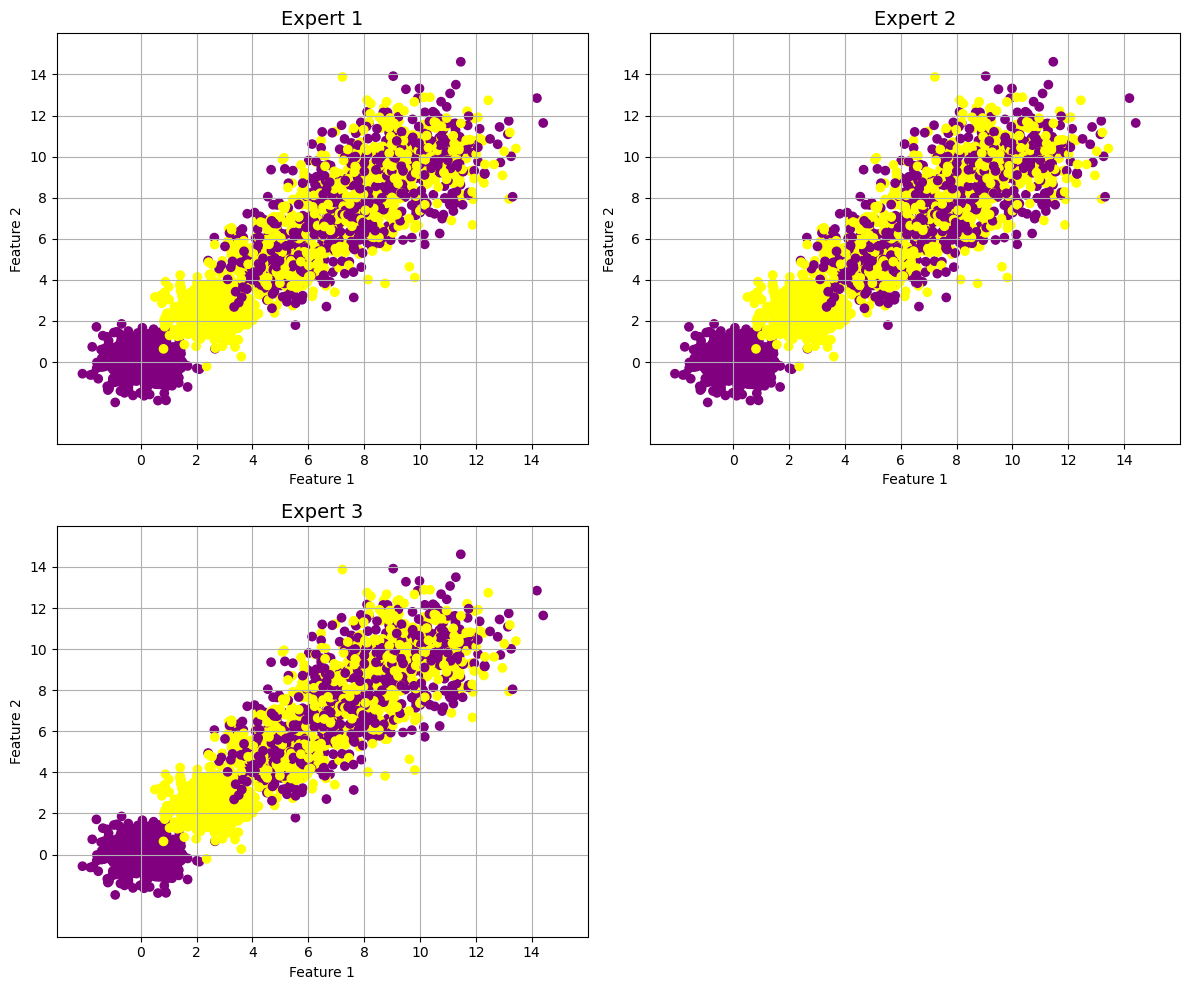

In [16]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))
plt.xlim(-3, 16)
plt.ylim(-4, 16)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap=custom_cmap)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))
plt.xlim(-3, 16)
plt.ylim(-4, 16)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap=custom_cmap)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Expert 3', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))
plt.xlim(-3, 16)
plt.ylim(-4, 16)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap=custom_cmap)
plt.grid(True)

plt.tight_layout()
plt.show()

In [111]:
d = 2
experts_id = [expert1]
experts_rand = [expert2, expert3]
k = len(experts_id) + len(experts_rand)
exp_id = [0]

m = Linear_net_rej_id(d,2,k) # 2 inputs
alpha = 0
p = 0.5

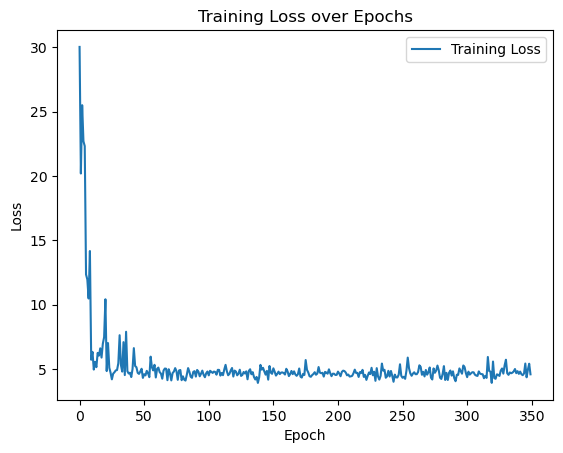

In [112]:
run_classifier_rej_id_rand(m, experts_id, experts_rand,  X_train, y_train, alpha, p, k)

In [113]:
exp_index_id = [[] for _ in range(k)]
exp_index_rand = [[] for _ in range(k)]
classifier_index = []

exp_index_rand, exp_index_id, classifier_index = classifier_rej_id_rand(m, experts_id, experts_rand, exp_id, X_test, y_test, p, k, exp_index_rand, exp_index_id, classifier_index)

system accuracy 54.13333333333333
total points: 750

Expert 1 defer count: 104
Expert 1 defer percent: 13.866666666666667
Expert 1 correct predictions: 58
Expert 1 accuracy: 55.7691235209163

Expert 3 defer count: 22
Expert 3 defer percent: 2.933333333333333
Expert 3 correct predictions: 12
Expert 3 accuracy: 54.5449586821938

Expert 4 defer count: 19
Expert 4 defer percent: 2.533333333333333
Expert 4 correct predictions: 19
Expert 4 accuracy: 99.99894737950127

Not deferred to any expert count: 605
Not deferred percent: 80.66666666666667
Model correct predictions: 317
Model accuracy: 52.39668555426685

Overall expert count: 145
Overall expert defer percent: 19.333333333333332
Overall expert correct predictions: 89
Overall expert accuracy: 61.37926801429792


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_35509/2876259632.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_35509/2876259632.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


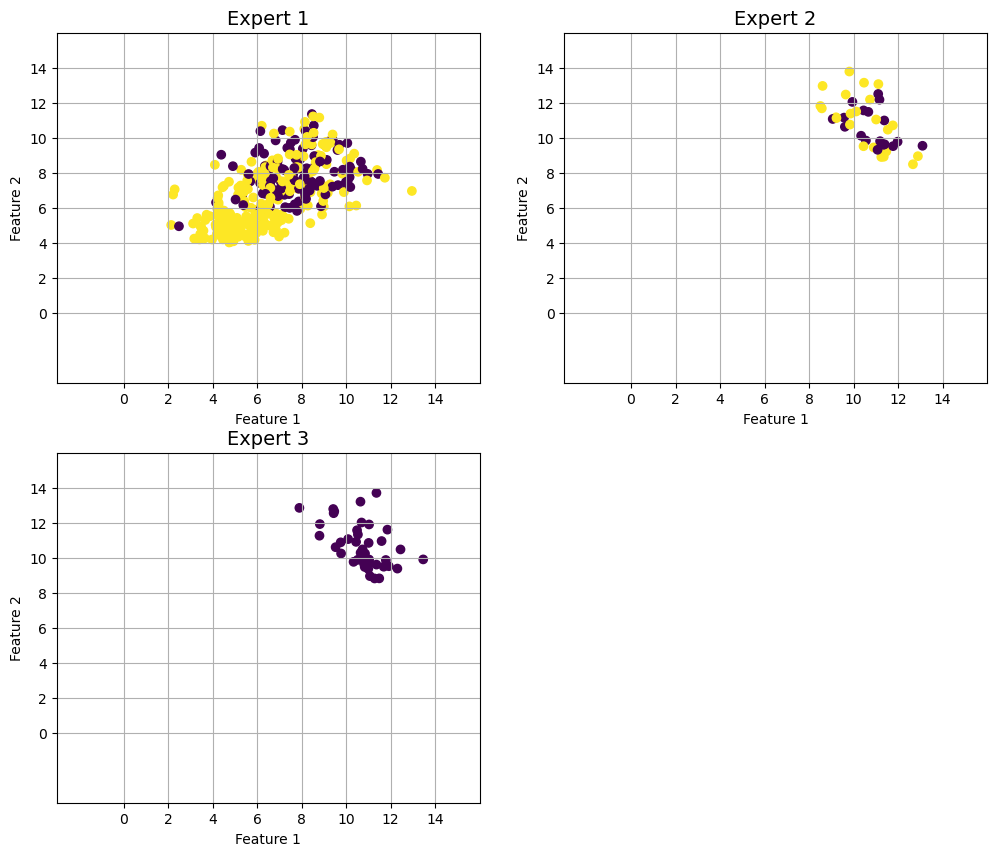

In [47]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))
plt.xlim(-3, 16)
plt.ylim(-4, 16)
plt.scatter(X_test[exp_index_id[0], 0], X_test[exp_index_id[0], 1], c=(torch.tensor(expert1(X_test[exp_index_id[0]])) == y_test[exp_index_id[0]])*1)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))
plt.xlim(-3, 16)
plt.ylim(-4, 16)
plt.scatter(X_test[exp_index_rand[0], 0], X_test[exp_index_rand[0], 1], c=(torch.tensor(expert2(X_test[exp_index_rand[0]])) == y_test[exp_index_rand[0]])*1)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Expert 3', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))
plt.xlim(-3, 16)
plt.ylim(-4, 16)
plt.scatter(X_test[exp_index_rand[1], 0], X_test[exp_index_rand[1], 1], c=(torch.tensor(expert3(X_test[exp_index_rand[1]])) == y_test[exp_index_rand[1]])*1)
plt.grid(True)

plt.show()

In [142]:
def getIndex(list_index):
    X_index = []
    for idx, j in enumerate(X):
        for i in list_index:
            if torch.equal(i, j):
                X_index.append(idx)
    return X_index

In [153]:
def getGroup(list_index):
    group_counts = {}
    for i in list_index:
        if i in group_index:
            val = group_index[i]
            if val in group_counts:
                group_counts[val] += 1
            else:
                group_counts[val] = 1
    return group_counts

In [157]:
rand1, rand2, id1, classifier = [], [], [], []
rand1 = getIndex(X_test[exp_index_rand[0]])
getGroup(rand1)

{4: 22}

In [158]:
rand2 = getIndex(X_test[exp_index_rand[1]])
getGroup(rand2)

{4: 19}

In [160]:
id1 = getIndex(X_test[exp_index_id[0]])
getGroup(id1)

{2: 25, 3: 45, 4: 34}

In [161]:
classifier = getIndex(X_test[classifier_index])
getGroup(classifier)

{0: 142, 1: 161, 2: 118, 3: 99, 4: 85}

In [164]:
X_test_group = getIndex(X_test)
getGroup(X_test_group)

{0: 142, 1: 161, 2: 143, 3: 144, 4: 160}